In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm import tqdm
import pandas as pd


from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import swyft
import pyro.distributions as dist

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

plt.rcParams.update({'font.size': 15})

from utils import *

from network import UNET, CustomHead

DEVICE = 'cuda'

In [3]:
# m = 10
# nsub = 1
# nsim = 10000

# lr = 1e-6
# factor = 3e-4
# patience = 5

In [2]:
def get_run(m, nsub, nsim):
    RUN = f'_m{m}_nsub{nsub}_nsim{nsim}'
    return RUN

def get_store(RUN):
    SIM_PATH = f'/nfs/scratch/eliasd/store{RUN}.zarr' 
    assert os.path.exists(f'/nfs/scratch/eliasd/store{RUN}.sync')
    store = swyft.DirectoryStore(path=SIM_PATH)
    print(f'Store has {len(store)} simulations')
    return store

def get_post(RUN, lr, factor, patience):
    save_name, save_path = get_name(RUN, lr, factor, patience)
    print(save_name)
    assert os.path.isfile(save_path)
    post = swyft.Posteriors.load(save_path).to(DEVICE)
    return post

In [4]:
def get_losses(post):
        
    keys = list(post._ratios.keys())
    assert len(keys) == 1
    losses = post._ratios[keys[0]]._train_diagnostics
    assert len(losses) == 1
    tl = losses[0]['train_loss']
    vl = losses[0]['valid_loss']
    epochs = np.arange(len(tl))
    return epochs, tl, vl

def plot_losses(post, title = ''):
    fig, ax = plt.subplots(1, 1)
    
    epochs, tl, vl = get_losses(post)
        
    ax.plot(epochs, tl, '--', label = f'training loss')
    ax.plot(epochs, vl, '-', label = f'val loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    plt.legend()
    plt.show()

In [5]:
RUN_10 = get_run(10, 1, 10000)
store_10 = get_store(RUN_10)

RUN_11 = get_run(11, 1, 10000)
store_11 = get_store(RUN_11)

Loading existing store.
Store has 10056 simulations
Loading existing store.
Store has 9982 simulations


In [6]:
post = get_post(RUN_10, 1e-3, 1e-1, 5)

UNet_m10_nsub1_nsim10000_lr-3.0_fac-1.0_pat5.pt


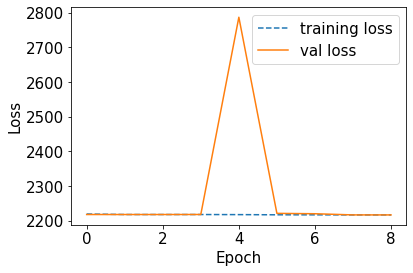

In [7]:
plot_losses(post)

In [134]:
lr_exps = np.arange(-7, 0)

posts = []
for lr_exp in lr_exps:
    lr = pow(10., lr_exp)
    post = get_post(RUN_10, lr, 3e-4, 5)
    posts.append(post)
    
    


In [57]:
post_a = get_post(RUN_11, 1e-3, 3e-4, 5)
post_b = get_post(RUN_11, 1e-4, 3e-4, 5)

-7


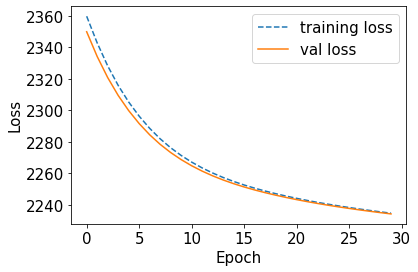

-6


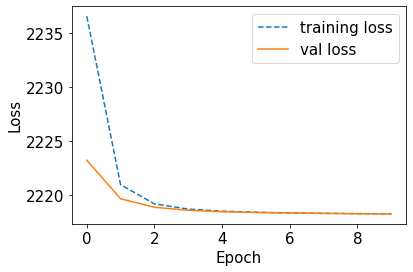

-5


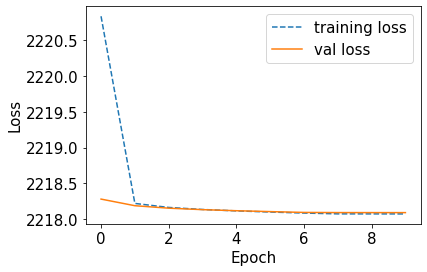

-4


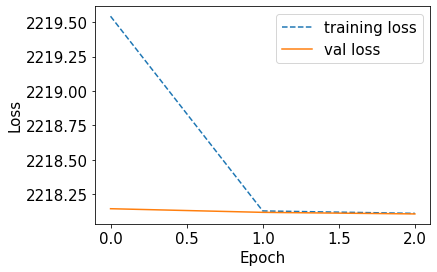

-3


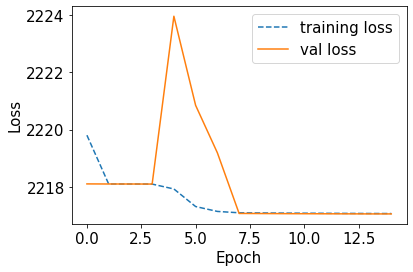

-2


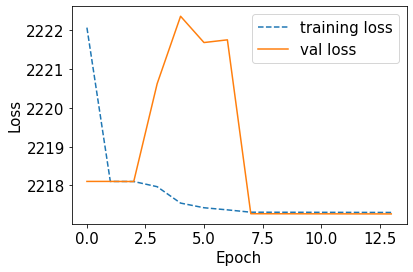

-1


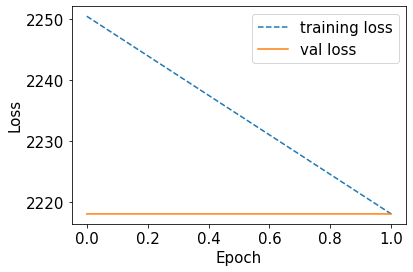

In [136]:
for post, lr_exp in zip(posts, lr_exps):
    print(lr_exp)
    plot_losses(post)

In [137]:
obs_10 = np.array([store_10[i][0]['image'] for i in range(5000)])
v_10 = np.array([store_10[i][1] for i in range(5000)])
obs_10mean = np.mean(obs_10, axis = 0)

obs_11 = np.array([store_11[i][0]['image'] for i in range(5000)])
v_11 = np.array([store_11[i][1] for i in range(5000)])
obs_11mean = np.mean(obs_11, axis = 0)

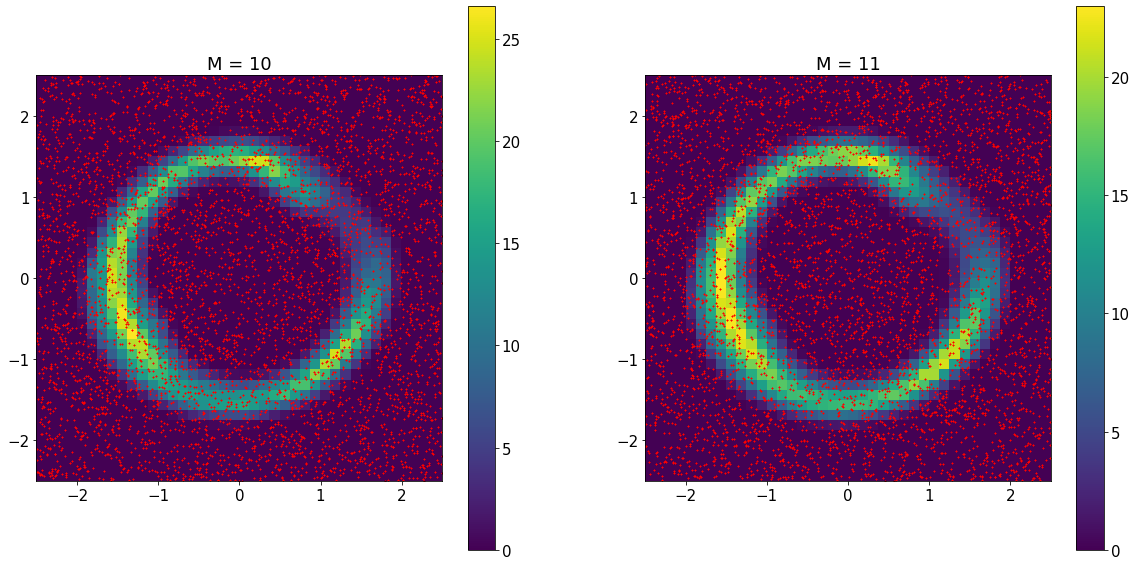

In [138]:
fig, axs = plt.subplots(1, 2, figsize = (20, 10))

ax = axs[0]
ax.scatter(*v_10.T, marker = 'x', color = 'r', s = 1)
im = ax.imshow(obs_10mean, **imkwargs)
fig.colorbar(im, ax = ax)
ax.set_title('M = 10')

ax = axs[1]
ax.scatter(*v_11.T, marker = 'x', color = 'r', s = 1)
im = ax.imshow(obs_11mean, **imkwargs)
fig.colorbar(im, ax = ax)
ax.set_title('M = 11')

plt.show()

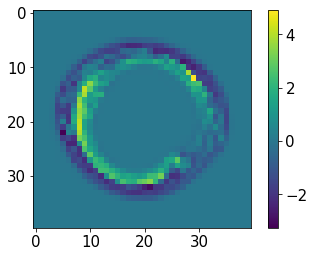

In [100]:
plt.imshow(obs_10mean - obs_11mean)
plt.colorbar()
plt.show()

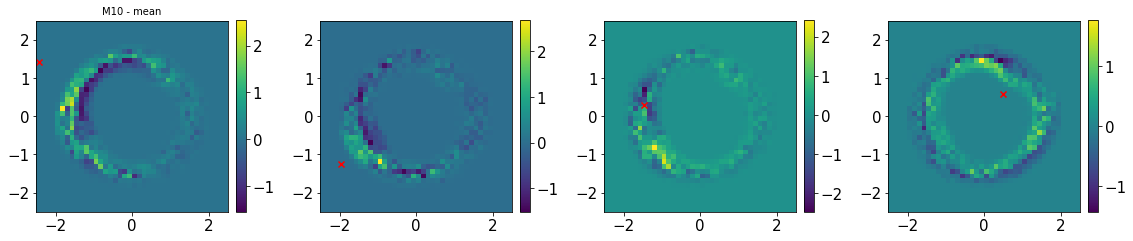

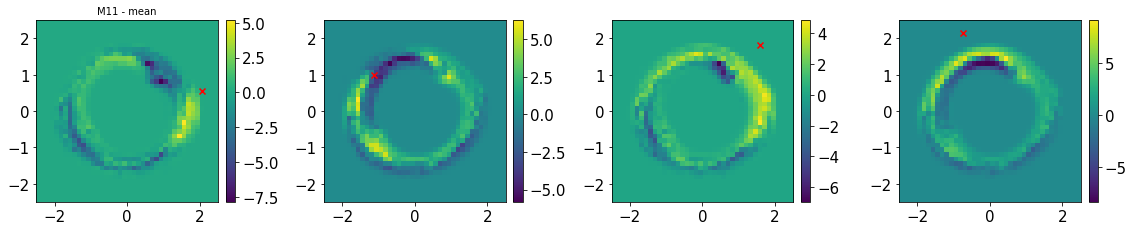

In [101]:
t = 4

plt_imshow([obs_10mean - obs for obs in obs_10[:t]], nrows = 1, 
           scatter = v_10[:t],
           cbar = True, tl = True, 
           titles = ['M10 - mean'] + ['']*(t-1), 
           **imkwargs)

plt_imshow([obs_11mean - obs for obs in obs_11[:t]], nrows = 1, 
           scatter = v_11[:t],
           cbar = True, tl = True, 
           titles = ['M11 - mean'] + ['']*(t-1), 
           **imkwargs)

In [ ]:
assert 1 == 2

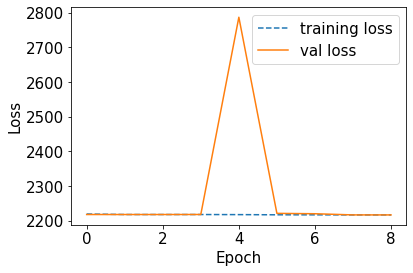

In [8]:
plot_losses(post)

In [9]:
uuu = UNET(1, 1)

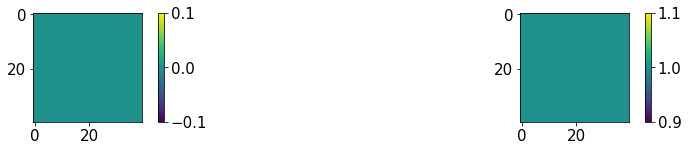

In [10]:
L = 40
grid = torch.linspace(0,(L-1)/L,L)
x, y = torch.meshgrid(grid, grid, indexing = 'xy')
xy_full = torch.transpose(torch.stack((x.flatten(), y.flatten())), 0, 1).flatten()
xy_empty = tensor(())

plots = [uuu.coord_to_map(xy.view(1, -1).to(DEVICE)).cpu().squeeze() for xy in [xy_empty, xy_full]]
plt_imshow(plots, cbar = True, size_y = 2)

In [11]:
def ratio(w):
    r = np.zeros((L**2))
    for i, (key, value) in enumerate(w.items()):
        r[i] = value
    return r.T.reshape(L, L)

def get_ratio(post, obs0, coords):
    samples = post.sample_elias(N = 1, obs0 = (obs0), n_batch = 1, v = coords.view(1, -1))
    v = samples['v']
    w = samples['weights']
    return ratio(w)

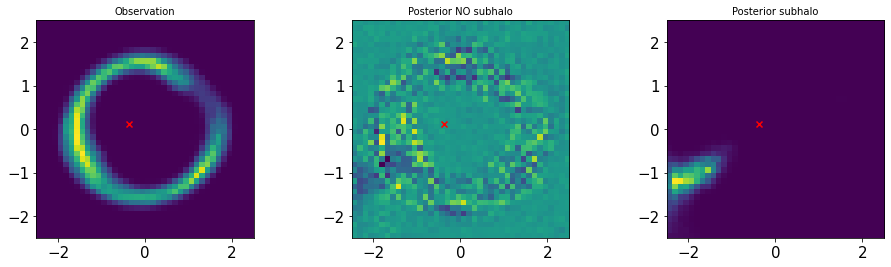

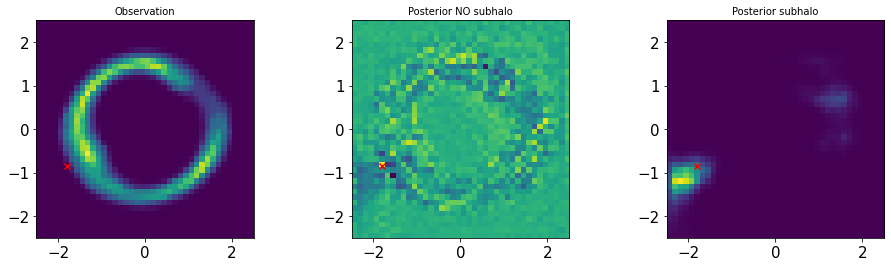

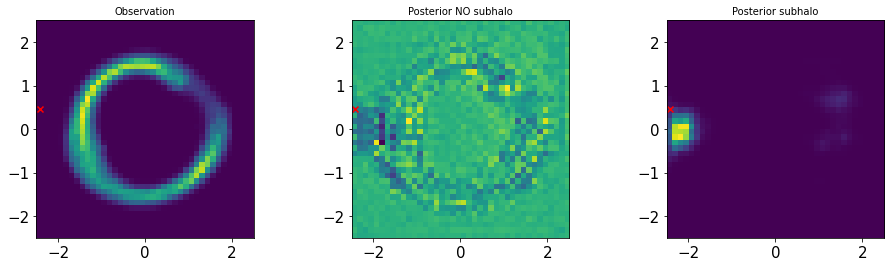

In [12]:
for post in [post]:

    p_1s = []
    v0s  = []
    for i in np.random.randint(0, len(store_11), 3):
        obs0 = store_11[i][0]
        v0 = store_11[i][1]

        p_0 = get_ratio(post, obs0, xy_empty)/(L*L)
        p_1 = get_ratio(post, obs0, xy_full)/(L*L)

        plots = [obs0['image'], p_0, p_1]
        plt_imshow(plots, titles = ['Observation', 'Posterior NO subhalo', 'Posterior subhalo'], scatter = [v0]*len(plots), size_y = 4, **imkwargs)

        p_1s.append(p_1)
        v0s.append(v0)


        plt.show()
        

# Play around

In [129]:
pow(10, 10)/pow(10, 10.5), pow(10, 11)

(0.31622776601683794, 100000000000)

In [126]:
1

SyntaxError: invalid syntax (3020995717.py, line 1)

In [12]:
get_losses(post)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [2236.5278441517066,
  2220.970490151263,
  2219.198417068373,
  2218.717267841312,
  2218.5234513519504,
  2218.4252721908247,
  2218.365275930851,
  2218.3247884114585,
  2218.294669076906,
  2218.270928565492],
 [2223.227001953125,
  2219.6690266927085,
  2218.88525390625,
  2218.604280598958,
  2218.473323567708,
  2218.3995279947917,
  2218.3507486979165,
  2218.317203776042,
  2218.291080729167,
  2218.270361328125])

In [140]:
1e-3 * 1e-4

1.0000000000000001e-07

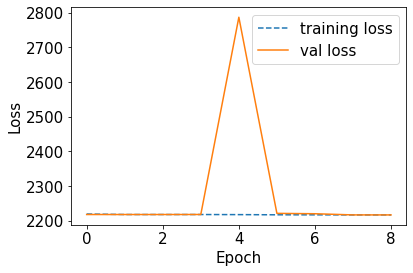

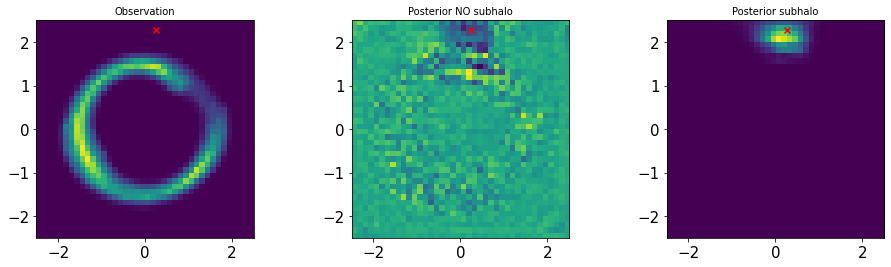

In [149]:
store = store_10



plot_losses(post)

for i in np.random.randint(0, len(store), 1):
    obs0 = store[i][0]
    v0 = store[i][1]

    p_0 = get_ratio(post, obs0, xy_empty)/(L*L)
    p_1 = get_ratio(post, obs0, xy_full)/(L*L)

    plots = [obs0['image'], p_0, p_1]
    plt_imshow(plots, titles = ['Observation', 'Posterior NO subhalo', 'Posterior subhalo'], scatter = [v0]*len(plots), size_y = 4, **imkwargs)    

    plt.show()

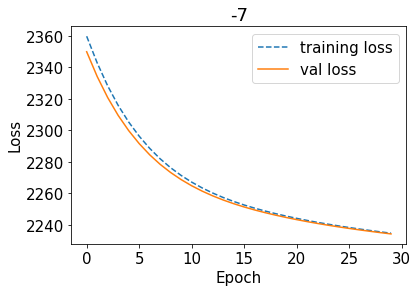

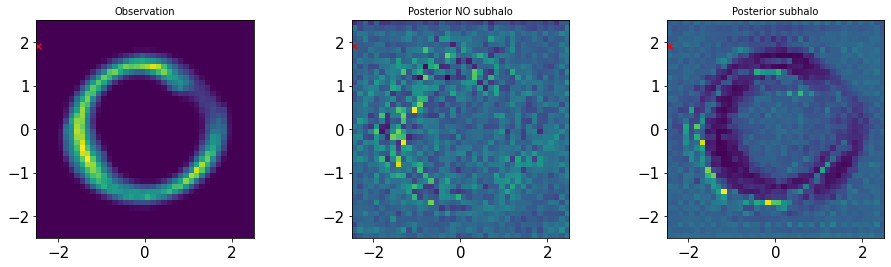

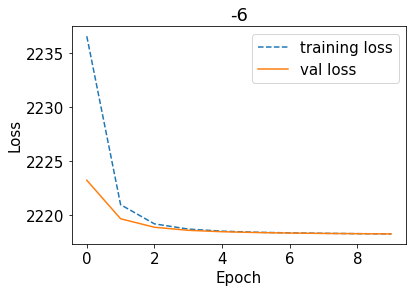

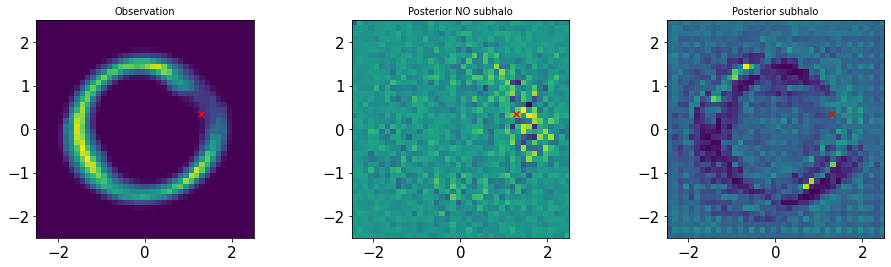

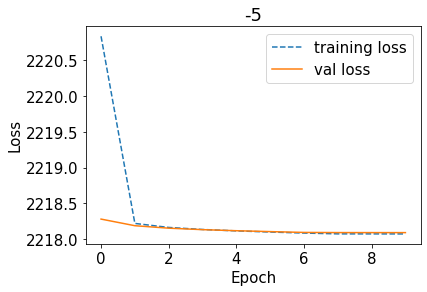

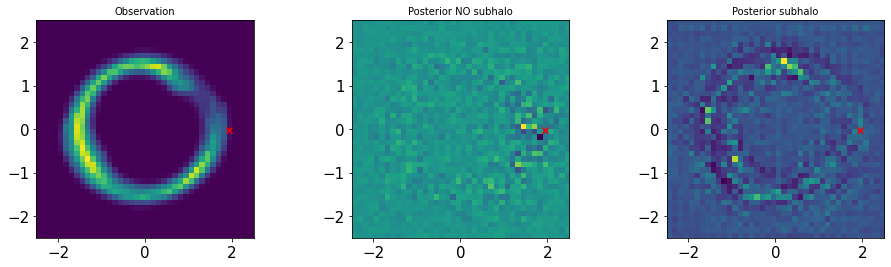

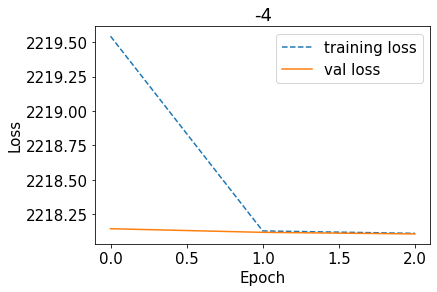

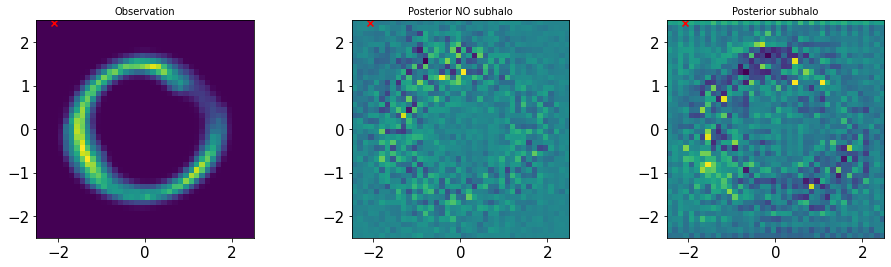

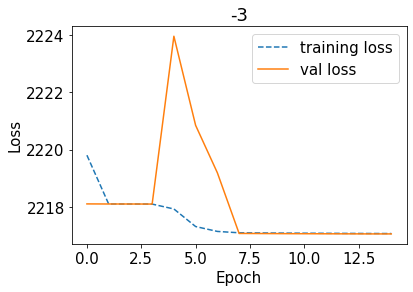

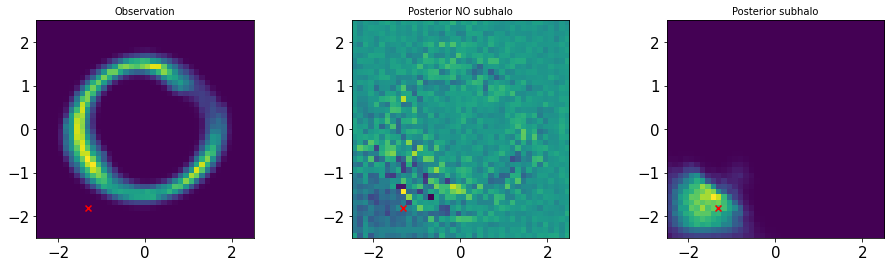

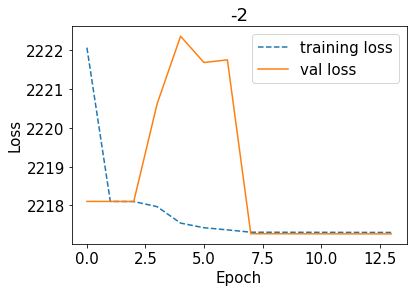

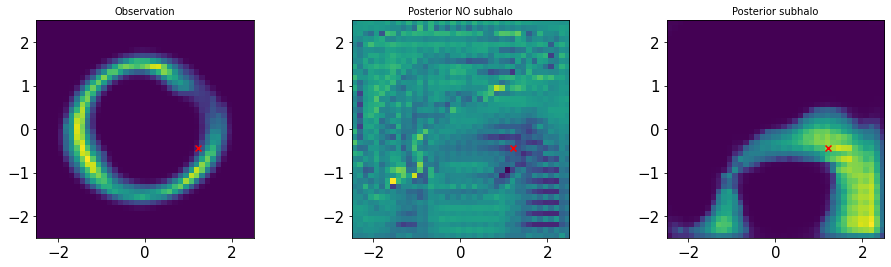

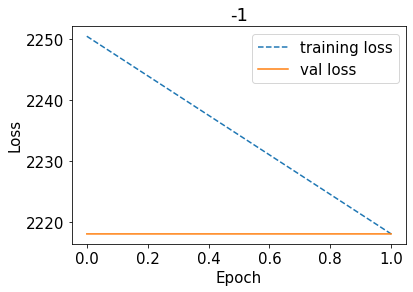

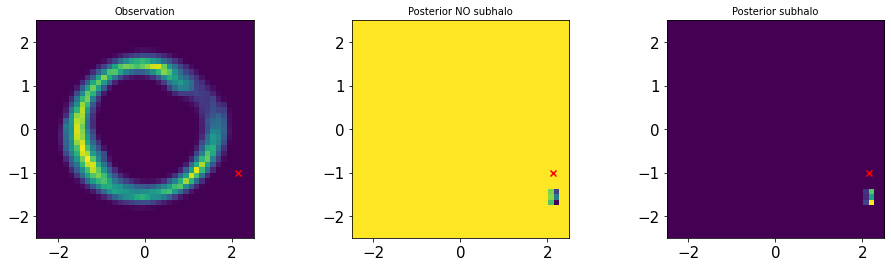

In [139]:
# plot_losses(post, r'$M = 10^{11} M_{\odot}$, $N_{SIM} = 10^{4}, N_{sub} = 3$, lr = $10^{-4}$')

store = store_10

for post, lr_exp in zip(posts, lr_exps):

    plot_losses(post, lr_exp)

    for i in np.random.randint(0, len(store), 1):
        obs0 = store[i][0]
        v0 = store[i][1]

        p_0 = get_ratio(post, obs0, xy_empty)/(L*L)
        p_1 = get_ratio(post, obs0, xy_full)/(L*L)

        plots = [obs0['image'], p_0, p_1]
        plt_imshow(plots, titles = ['Observation', 'Posterior NO subhalo', 'Posterior subhalo'], scatter = [v0]*len(plots), size_y = 4, **imkwargs)    

        plt.show()